In [2]:
import os
os.chdir('/data/l989o/deployed/a/')
print(os.getcwd())
from jupy import *

/data/l989o/deployed/a


In [2]:
from data import RawMeanDataset
import torch
import matplotlib.pyplot as plt
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          'text.color' : 'k',
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update(params)

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [3]:
from tqdm import tqdm
# not the proper way of getting channel-wise means and stds, but this is faster
def get_mu_std(split):
    ds = RawMeanDataset(split, filter_by_area=True)
    l = []
    cells = []
    for x in tqdm(ds):
        xx = torch.mean(x, dim=0).view(1, -1)
        l.append(xx)
        cells.append(x.shape[0])
    x = torch.cat(l, dim=0)
    # print(x.shape)
    # x = torch.log(x + 1)
    x = torch.asinh(x)
    mu, std = torch.mean(x, dim=0), torch.std(x, dim=0)
    return mu, std, x
mu0, std0, x = get_mu_std('train')
x0 = (x - mu0) / std0

100%|██████████| 389/389 [00:28<00:00, 13.86it/s]


In [4]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
ds = RawMeanDataset('train', filter_by_area=True)
for cell_expression in tqdm(ds):
    scaler.partial_fit(cell_expression)
mu1 = torch.from_numpy(scaler.mean_).float()
std1 = torch.from_numpy(scaler.var_).float().sqrt()
x1 = (x - mu1) / std1

100%|██████████| 389/389 [00:30<00:00, 12.66it/s]


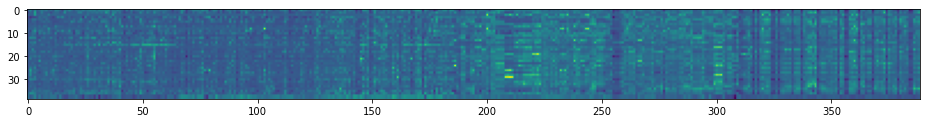

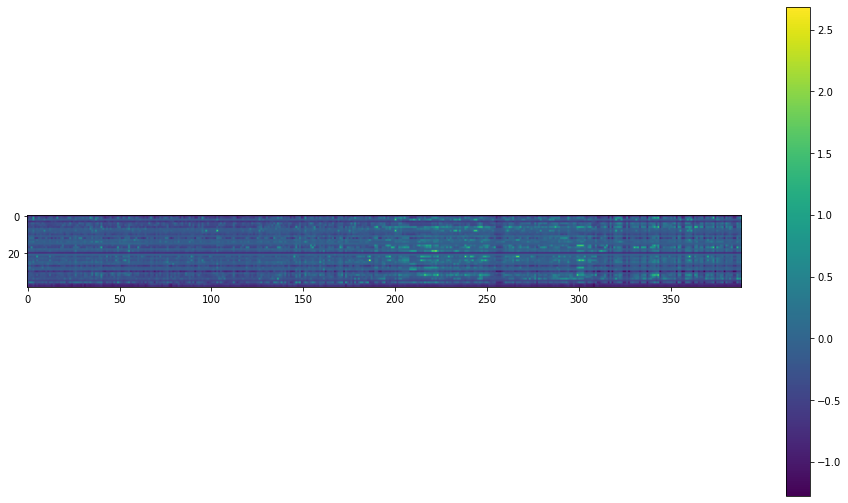

In [5]:
plt.figure(figsize=(16, 9))
plt.imshow(x0.t())
plt.show()

plt.figure(figsize=(16, 9))
plt.imshow(x1.t())
plt.colorbar()
plt.show()

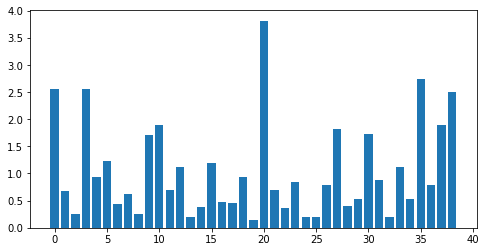

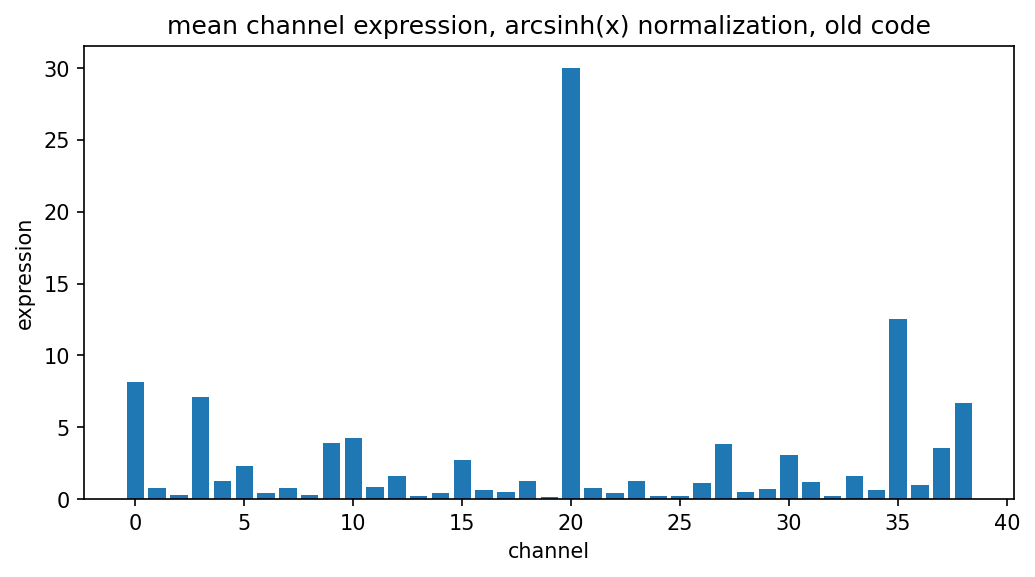

In [6]:
l = list(range(39))
plt.figure(figsize=(8, 4))
plt.bar(l, mu0)
plt.show()
#
plt.figure(figsize=(8, 4), dpi=150)
plt.title('mean channel expression, arcsinh(x) normalization, old code')
plt.xlabel('channel')
plt.ylabel('expression')
plt.bar(l, mu1)
plt.show()

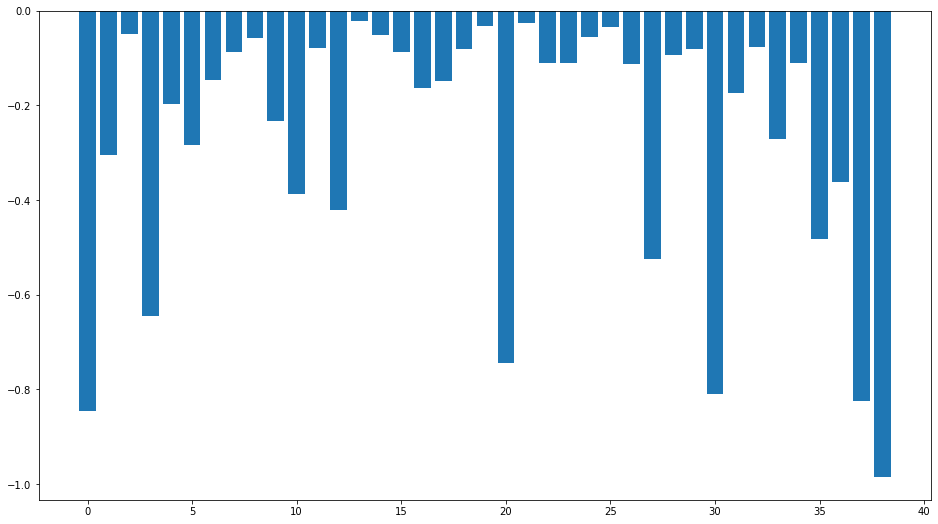

In [7]:
# mu_x1 = torch.mean(x1, dim=0)
# plt.figure(figsize=(16, 9))
# plt.bar(l, mu_x1)
# plt.show()

In [17]:
SPLIT = 'train'
# SPLIT = 'validation'
# SPLIT = 'test'

import math
from tqdm import tqdm

ds = RawMeanDataset(SPLIT, filter_by_area=True)
# scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
list_of_x = []
list_of_z = []
i = 0
d = {}
for i, x in enumerate(tqdm(ds)):
    # if i > 20:
    #     break
    # std = torch.std(x, dim=0)
    # x_scaled = x / std
    q0 = np.quantile(x.numpy(), q=0.9, axis=0)
    x0 = x / q0
    q1 = np.quantile(x0.numpy(), q=0.5, axis=0)
    if all(q1 < 1e-5):
        print(i - 1)
    # print(q.shape)
    # assert False
    # print(median)
    # print(median.shape)
    cofactor = q1 / math.sinh(1)
    z = np.arcsinh(x0 / cofactor)
    list_of_z.append(z)
    list_of_x.append(x)
    o = ds.filenames[i]
    d[o] = {'q0': q0, 'q1': q1}

f = os.path.join('data/spatial_uzh_processed/a', f'scaler_{SPLIT}.pickle')
import pickle
pickle.dump(d, open(f, 'wb'))
print("ehi")

100%|██████████| 389/389 [00:31<00:00, 12.42it/s]


ehi


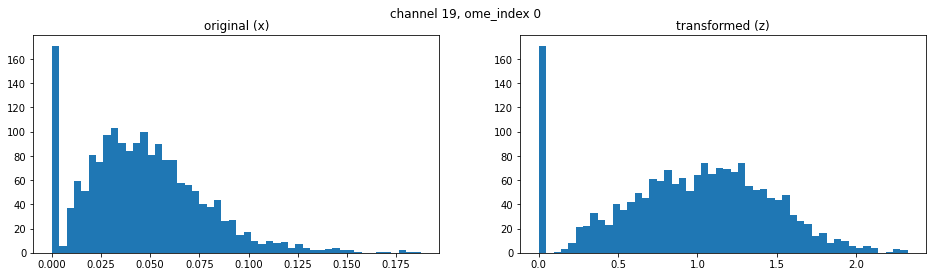

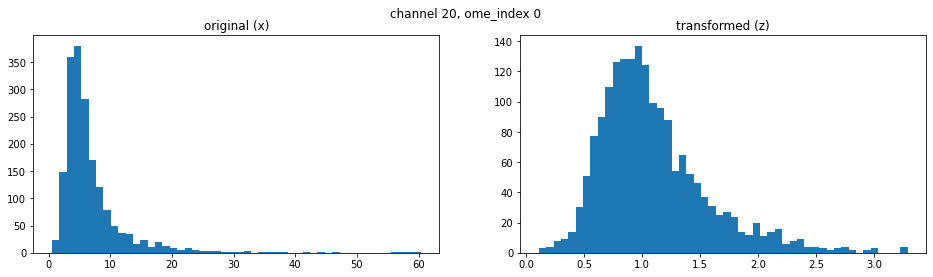

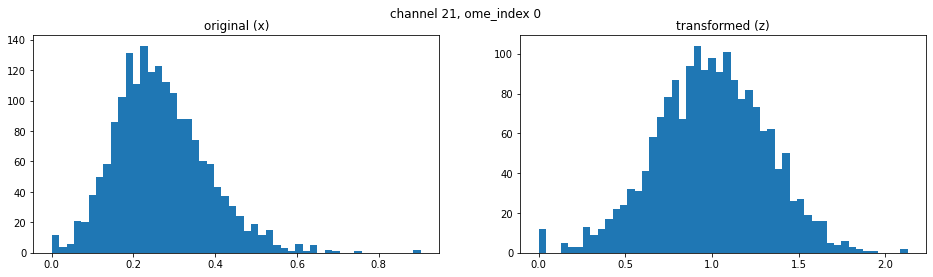

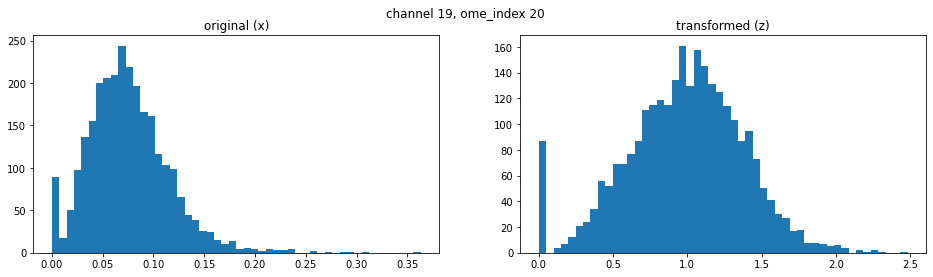

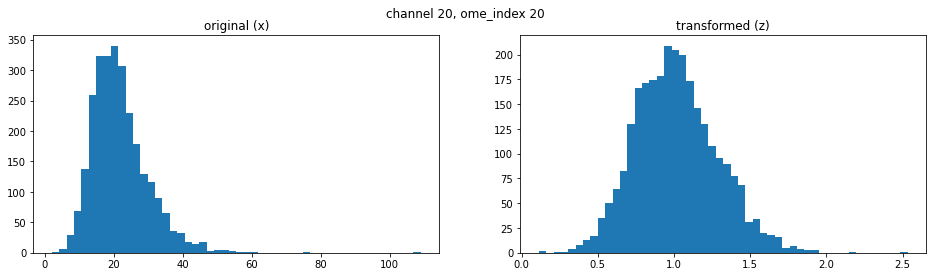

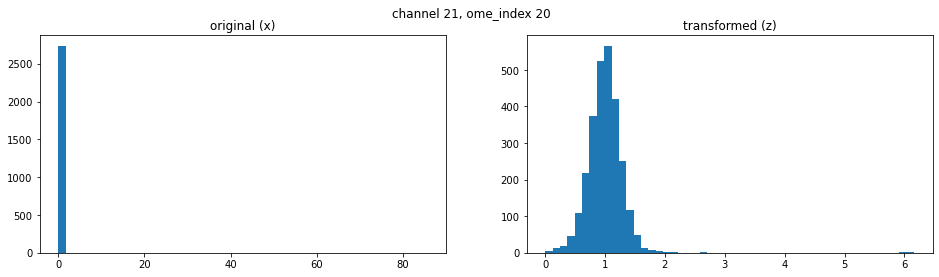

In [18]:
for i in [0, 20]:
    for c in [19, 20, 21]:
        x = list_of_x[i][:, c].numpy()
        z = list_of_z[i][:, c].numpy()
        # print(x.shape)
        # print(z.shape)

        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.hist(x, bins=50)
        plt.title('original (x)')
        plt.subplot(1, 2, 2)
        plt.hist(z, bins=50)
        plt.title('transformed (z)')
        plt.suptitle(f'channel {c}, ome_index {i}')
        plt.show()

In [19]:
# x = torch.cat(list_of_x, dim=0)
# z = torch.cat(list_of_z, dim=0)
#
# log_x = torch.log(x + 1)
# mu, std = torch.mean(log_x, dim=0), torch.std(log_x, dim=0)
# log_x_transformed = (log_x - mu) / std
# print(x.shape)


In [20]:
print(len(list_of_x))
print(len(list_of_z))
a = []
b = []
for i in range(len(list_of_x)):
    x = torch.mean(list_of_x[i], dim=0).view((1, -1))
    y = torch.mean(list_of_z[i], dim=0).view((1, -1))
    a.append(x)
    b.append(y)
aa = torch.cat(a, dim=0)
bb = torch.cat(b, dim=0)

389
389


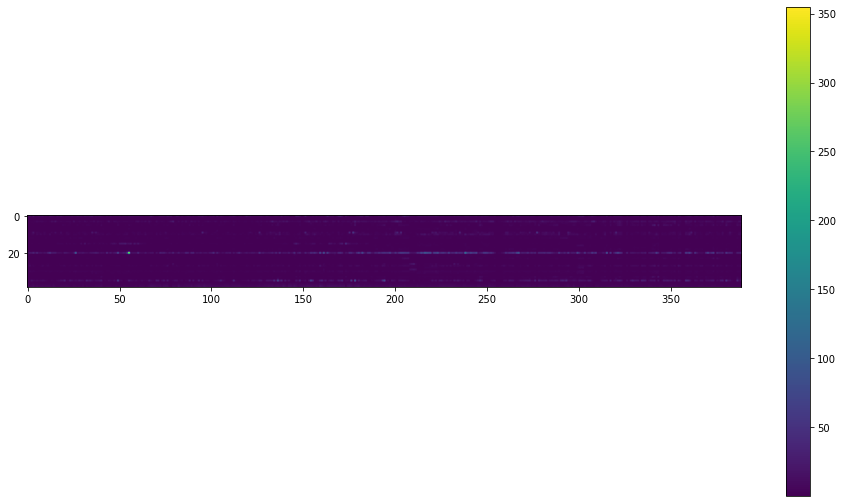

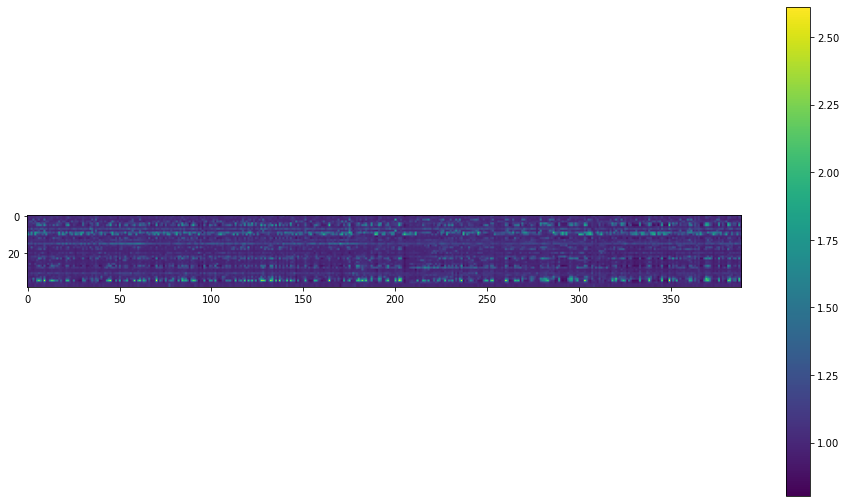

In [21]:
plt.figure(figsize=(16, 9))
plt.imshow(aa.t())
plt.colorbar()
# plt.clim(0, 5)
plt.show()

plt.figure(figsize=(16, 9))
plt.imshow(bb.t())
plt.colorbar()
plt.show()
#
# plt.figure(figsize=(16, 9))
# plt.imshow(log_x_transformed.t())
# plt.colorbar()
# plt.show()

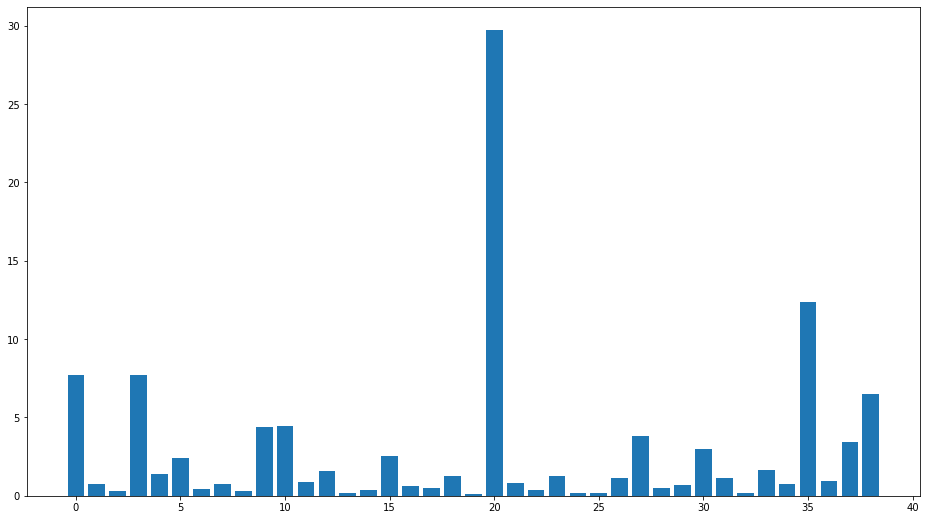

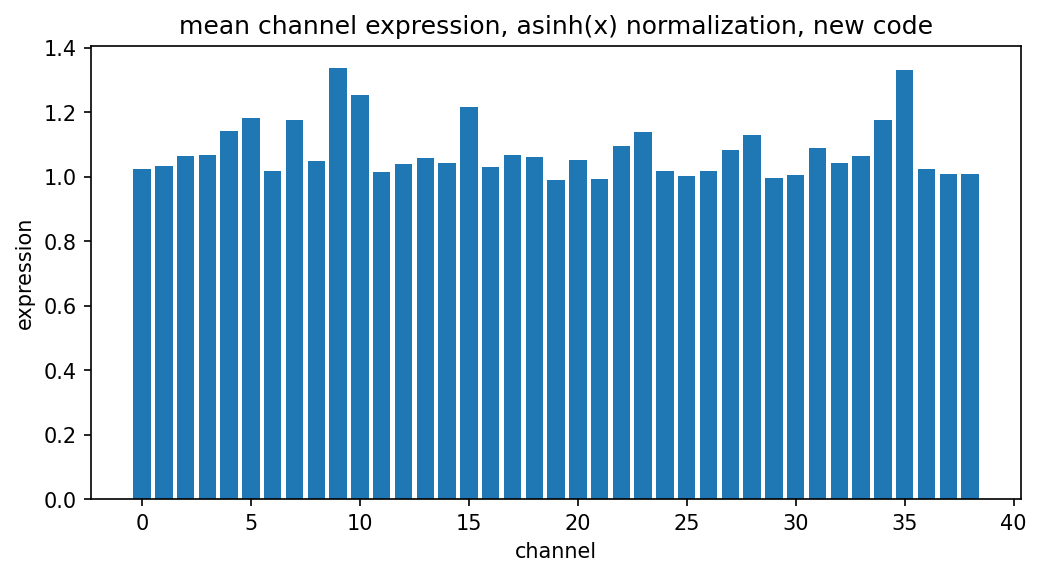

In [22]:
l = list(range(39))
plt.figure(figsize=(16, 9))
plt.bar(l, torch.mean(aa, dim=0))
plt.show()

l = list(range(39))
plt.figure(figsize=(8, 4), dpi=150)
plt.title('mean channel expression, asinh(x) normalization, new code')
plt.xlabel('channel')
plt.ylabel('expression')
plt.bar(l, torch.mean(bb, dim=0))
plt.show()